## DATATHON HEY BANCO

# Importación de librerías

In [44]:
import numpy as np # For numerical operations
import pandas as pd # For Data Organization, Wrangling & Cleaning
import matplotlib.pyplot as plt # For plotting
import matplotlib.lines as mlines # For plotting
import seaborn as sns # For plotting
import plotly.express as px # For plotting

import scipy.stats as stats # For generating random numbers distributions
import statsmodels.formula.api as sm # For statistical modeling (e.g. OLS)

from sklearn.tree import DecisionTreeRegressor # Regression Decision Trees
from sklearn.tree import DecisionTreeClassifier # Classification Decision Trees
from sklearn.tree import plot_tree # For Decision Tree Visualization
from sklearn.metrics import mean_squared_error # For RegDT Performance Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score # For ClassDT Perf Metrics
from sklearn.metrics import precision_score, recall_score # For ClassDT PM
from sklearn.metrics import roc_curve, roc_auc_score # For ClassDT Perf Metrics
from sklearn.model_selection import train_test_split # For splitting data
# KFold for "Manual" Cross-Validation (CV) / cross_val_score for Automatic CV
# StratifiedKFold useful for imbalanced datasets, folds with same proportions
from sklearn.model_selection import KFold, cross_val_score,  StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier # For ensemble methods
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# Relevant data cleaning

In [45]:
clients = pd.read_csv("base_clientes_final.csv")
transactions = pd.read_csv("base_transacciones_final.csv")

print(clients.shape)
print(clients.head(3))

(1000, 8)
                                         id fecha_nacimiento  fecha_alta  \
0  9980f12e32711330d5f58460e169e6207afda041       19/06/1984  25/10/2015   
1  93512ea145c3d81ba7a7ff641faf992fd307072e       21/12/1986  11/02/2018   
2  acb2fee5aea2d73a88359d438aaedeea731554f8       01/02/1991  12/05/2019   

   id_municipio  id_estado                              tipo_persona genero  \
0       6822006         68  Persona Fisica Sin Actividad Empresarial          
1       6822014         68  Persona Fisica Con Actividad Empresarial      F   
2       6115121         61  Persona Fisica Con Actividad Empresarial      M   

                    actividad_empresarial  
0           EMPLEADO DEL SECTOR SERVICIOS  
1  COMPRAVENTA DE ARTICULOS DE FERRETERIA  
2                   AGENCIA DE PUBLICIDAD  


In [46]:
print(clients.info())
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     1000 non-null   object
 1   fecha_nacimiento       1000 non-null   object
 2   fecha_alta             1000 non-null   object
 3   id_municipio           1000 non-null   int64 
 4   id_estado              1000 non-null   int64 
 5   tipo_persona           1000 non-null   object
 6   genero                 1000 non-null   object
 7   actividad_empresarial  1000 non-null   object
dtypes: int64(2), object(6)
memory usage: 62.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346011 entries, 0 to 346010
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             346011 non-null  object 
 1   fecha          346011 non-null  object 
 2   comercio       346011 non-null  ob

In [47]:
print(transactions.columns)

Index(['id', 'fecha', 'comercio', 'giro_comercio', 'tipo_venta', 'monto'], dtype='object')


In [48]:
# These categories seem to have intrinsic order
transactions['giro_comercio'] = transactions.giro_comercio.map(
    {'COMERCIOS ELECTRONICOS (VTAS POR INTERNET)': 1,
     'SERVICIOS EMPRESARIALES - NO CLASIFICADOS': 2,
     'SERV GUBERNAM, AGUA, ELECTRICIDAD,PREDIAL,TENENCIA': 2,
     'TIENDAS DE CONVENIENCIA, MINISUPER': 1,
     'DROGUERIAS, (FARMACIAS)': 2,
     'AUTOSERVICIOS Y SUPERMERCADOS': 1,
     'TRASLADOS - FLETES, (SERVICIOS DE MENSAJERIA)': 1,
     'LIMOSINAS, (TAXIS)': 1,
     'TIENDA DEPARTAMENTAL': 1,
     'AGREGADOR': 0,
     'CLUBES DE MAYORISTA': 1,
     'ESTACIONES DE SERVICIO, GASOLINERIAS TODO TRANSPOR': 2,
     'COMIDA RAPIDA': 0,
     'RESTAURANTES': 1,
     'MERCADO DIRECTO - VENTAS POR CATALOGO': 1
     }
)

# Eliminar múltiples columnas
transactions = transactions.drop(['tipo_venta'], axis=1)
# Otras columnas: , 'comercio', 'fecha'

# Convertir datos a formato de fecha
clients["fecha_alta"] = pd.to_datetime(clients["fecha_alta"], format="%d/%m/%Y")
transactions["fecha"] = pd.to_datetime(transactions["fecha"], format="%d/%m/%Y")

In [49]:
print(transactions.shape)
print(transactions.head(5))

(346011, 5)
                                         id      fecha comercio  \
0  91477f382c3cf63ab5cd9263b502109243741158 2022-01-02   AMAZON   
1  91477f382c3cf63ab5cd9263b502109243741158 2022-01-05    RAPPI   
2  91477f382c3cf63ab5cd9263b502109243741158 2022-01-05    RAPPI   
3  91477f382c3cf63ab5cd9263b502109243741158 2022-01-05   AMAZON   
4  91477f382c3cf63ab5cd9263b502109243741158 2022-01-05   AMAZON   

   giro_comercio  monto  
0            1.0   5.99  
1            2.0  13.01  
2            2.0  15.84  
3            1.0   8.17  
4            1.0   2.54  


In [50]:
# Obtener última fecha de transacción por cliente
ultima_transaccion = transactions.groupby("id")["fecha"].max().reset_index()
ultima_transaccion.columns = ["id", "fecha_ultima_transaccion"]

# Unir con base de clientes
clientes_actividad = pd.merge(clients, ultima_transaccion, on="id", how="left")

# Calcular antigüedad activa en días (puedes dividir entre 30 o 365 si prefieres meses o años)
clientes_actividad["antiguedad_activa_dias"] = (
    clientes_actividad["fecha_ultima_transaccion"] - clientes_actividad["fecha_alta"]
).dt.days

# Mostrar algunos resultados
print(clientes_actividad[["id", "fecha_alta", "fecha_ultima_transaccion", "antiguedad_activa_dias"]].head())

                                         id fecha_alta  \
0  9980f12e32711330d5f58460e169e6207afda041 2015-10-25   
1  93512ea145c3d81ba7a7ff641faf992fd307072e 2018-02-11   
2  acb2fee5aea2d73a88359d438aaedeea731554f8 2019-05-12   
3  b627227d2f20116510bcb12de34e6a188cf8d054 2017-07-19   
4  054be5f40d50b28d2b82af57159343989dd28012 2017-05-21   

  fecha_ultima_transaccion  antiguedad_activa_dias  
0               2023-01-28                    2652  
1               2023-01-27                    1811  
2               2023-01-21                    1350  
3               2023-01-30                    2021  
4               2023-01-30                    2080  


In [51]:
# Mean of 'giro_comercio' by 'id'
giro_comercio_mean = transactions.groupby('id')['giro_comercio'].mean().reset_index()
giro_comercio_mean.columns = ['id', 'giro_comercio_mean']
print(giro_comercio_mean.shape)
print(giro_comercio_mean.head(5))

# Sum of 'monto' by 'id'
monto_sum = transactions.groupby('id')['monto'].sum().reset_index()
monto_sum.columns = ['id', 'monto_sum']
print(monto_sum.shape)
print(monto_sum.head(5))

(1000, 2)
                                         id  giro_comercio_mean
0  003d9abe467a91847d566cf455bd2d7d6c8f7e75            0.807169
1  0066f66c7fb0d1102f9f924a56ff65a5fcaf3cea            1.029954
2  0132462ee1acf1c37e7411b20bac94e1d19959df            0.829912
3  0172891ba3000c3150a6985265517678ebbf3b39            0.492537
4  01d12d1c5b58348995b71cf1d5eb9257fa64d95b            0.824859
(1000, 2)
                                         id  monto_sum
0  003d9abe467a91847d566cf455bd2d7d6c8f7e75   12908.93
1  0066f66c7fb0d1102f9f924a56ff65a5fcaf3cea   24285.80
2  0132462ee1acf1c37e7411b20bac94e1d19959df   10786.89
3  0172891ba3000c3150a6985265517678ebbf3b39    9467.26
4  01d12d1c5b58348995b71cf1d5eb9257fa64d95b   19901.69


In [74]:
# new dataframe with merged dataframes
df = pd.merge(clientes_actividad, giro_comercio_mean, on="id", how="left")

# Merge the result with monto_sum
df = pd.merge(df, monto_sum, on="id", how="left")

df["id_int"] = pd.factorize(df["id"])[0]

new_df = df[['id_int', 'giro_comercio_mean', 'monto_sum', 'antiguedad_activa_dias']].copy()

# Merge df and new_df
both_id = pd.merge(df, new_df, on="id_int", how="left")

print(new_df.shape)
print(new_df.head(5))

print('both ID')
print(both_id.shape)
print(both_id.head(5))

(1000, 4)
   id_int  giro_comercio_mean  monto_sum  antiguedad_activa_dias
0       0            1.196481   11396.81                    2652
1       1            1.414530   17346.26                    1811
2       2            0.645161    7110.06                    1350
3       3            0.887324   14264.99                    2021
4       4            1.026882   13470.72                    2080
both ID
(1000, 16)
                                         id fecha_nacimiento fecha_alta  \
0  9980f12e32711330d5f58460e169e6207afda041       19/06/1984 2015-10-25   
1  93512ea145c3d81ba7a7ff641faf992fd307072e       21/12/1986 2018-02-11   
2  acb2fee5aea2d73a88359d438aaedeea731554f8       01/02/1991 2019-05-12   
3  b627227d2f20116510bcb12de34e6a188cf8d054       23/05/1994 2017-07-19   
4  054be5f40d50b28d2b82af57159343989dd28012       03/10/1990 2017-05-21   

   id_municipio  id_estado                              tipo_persona genero  \
0       6822006         68  Persona Fisica Sin Acti

In [53]:
print(monto_sum)


                                           id  monto_sum
0    003d9abe467a91847d566cf455bd2d7d6c8f7e75   12908.93
1    0066f66c7fb0d1102f9f924a56ff65a5fcaf3cea   24285.80
2    0132462ee1acf1c37e7411b20bac94e1d19959df   10786.89
3    0172891ba3000c3150a6985265517678ebbf3b39    9467.26
4    01d12d1c5b58348995b71cf1d5eb9257fa64d95b   19901.69
..                                        ...        ...
995  fdf02d0a51b8680e60bdb3aec28553729f2d4145    7950.96
996  fe25435085da4e8b314592f5aab3655699ea1894   12230.17
997  fe29a4b444e0c24c7efb5c4c5209e25e08893716    7424.22
998  fe9415c62193f2d430a0340c31064ec512b27c8c   13196.63
999  ff67da037fae796809be0e36fb9cdd0e191c38a4   17879.34

[1000 rows x 2 columns]


# Decission Tree

Umbrales calculados:
- Antigüedad: 1174 días
- Monto: $12,061.25

Distribución de segmentos:
Segmento 0 (Antiguedad Baja + Monto Bajo): 265 clientes (26.5%)
Segmento 1 (Antiguedad Baja + Monto Alto): 235 clientes (23.5%)
Segmento 2 (Antiguedad Alta + Monto Bajo): 235 clientes (23.5%)
Segmento 3 (Antiguedad Alta + Monto Alto): 265 clientes (26.5%)

Features shape: (1000, 4)
Target shape: (1000,)
Training set: (800, 4), Test set: (200, 4)

=== MODEL PERFORMANCE ===
Training Accuracy: 1.000
Test Accuracy: 0.995

Feature Importance:
- id_int: 0.0000
- giro_comercio_mean: 0.0000
- monto_sum: 0.6667
- antiguedad_activa_dias: 0.3333

Confusion Matrix:
[[53  0  0  0]
 [ 1 46  0  0]
 [ 0  0 47  0]
 [ 0  0  0 53]]

Classification Report:
                     precision    recall  f1-score   support

Ant.Baja+Monto.Bajo       0.98      1.00      0.99        53
Ant.Baja+Monto.Alto       1.00      0.98      0.99        47
Ant.Alta+Monto.Bajo       1.00      1.00      1.00        47
Ant.Alta+Monto.Al

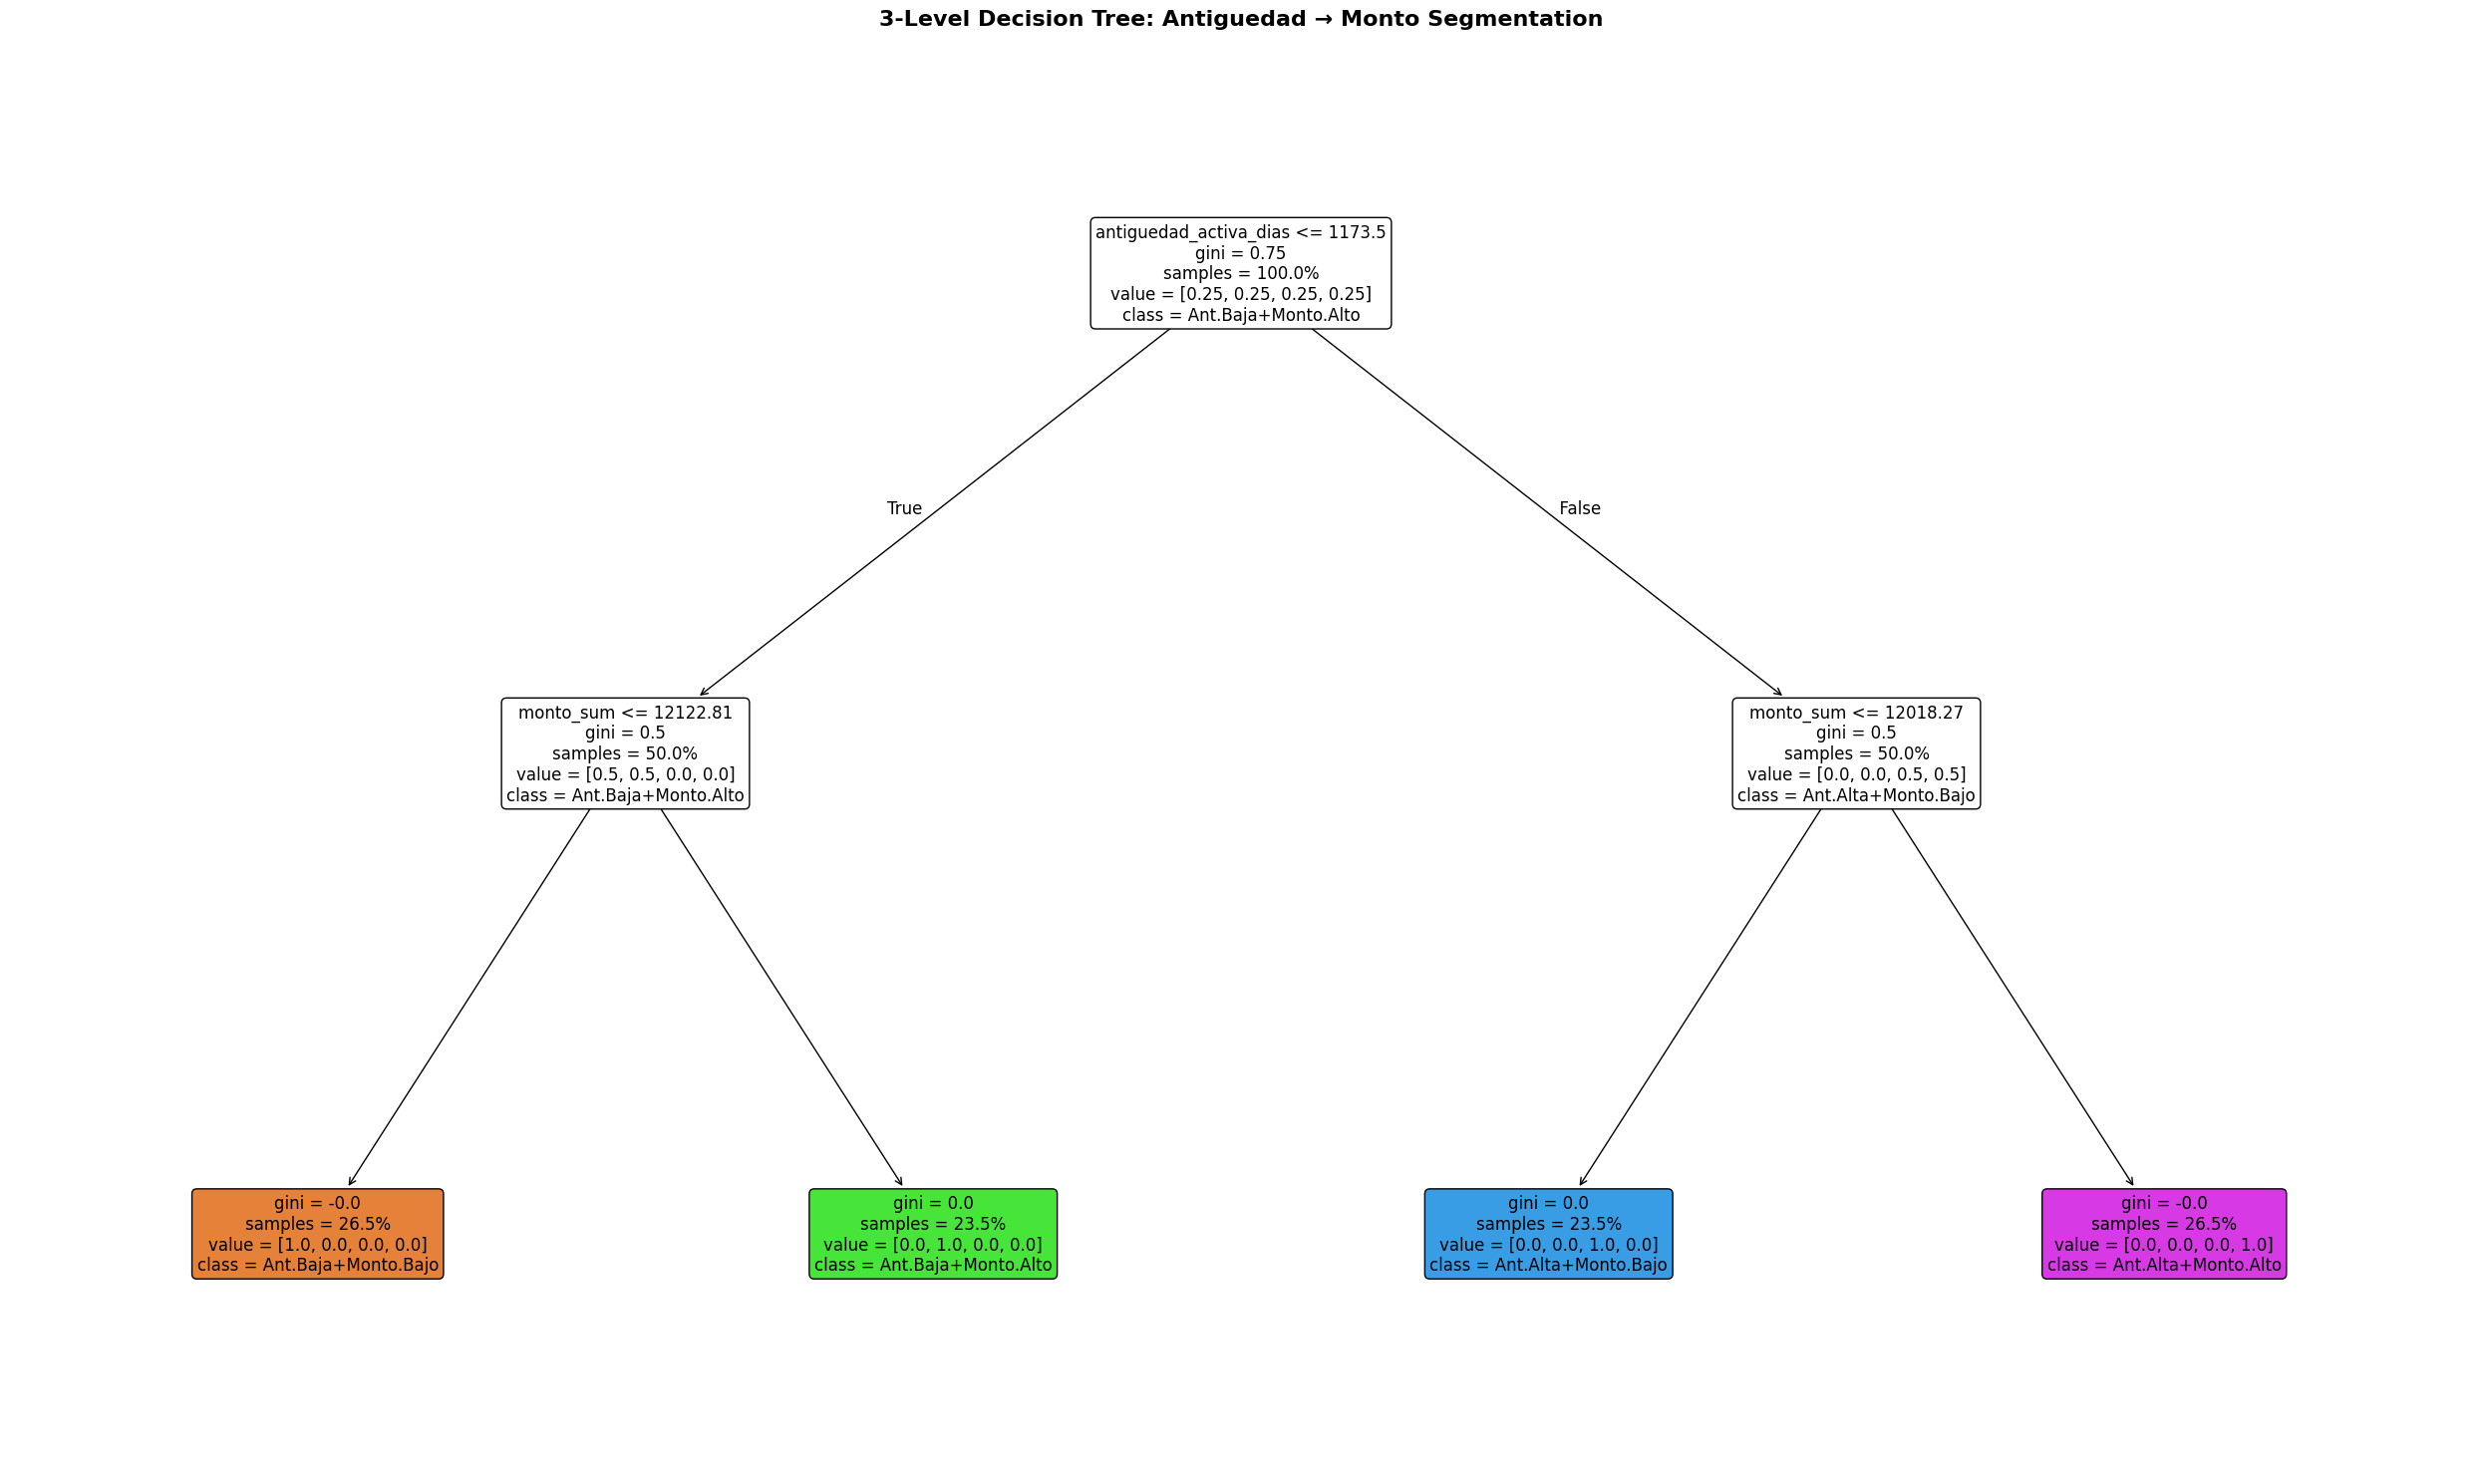


=== MANUAL SEGMENTATION VERIFICATION ===
Segmento 0: 265 clientes (26.5%)
Segmento 1: 235 clientes (23.5%)
Segmento 2: 235 clientes (23.5%)
Segmento 3: 265 clientes (26.5%)

Tree vs Manual Segmentation Match Rate: 0.999


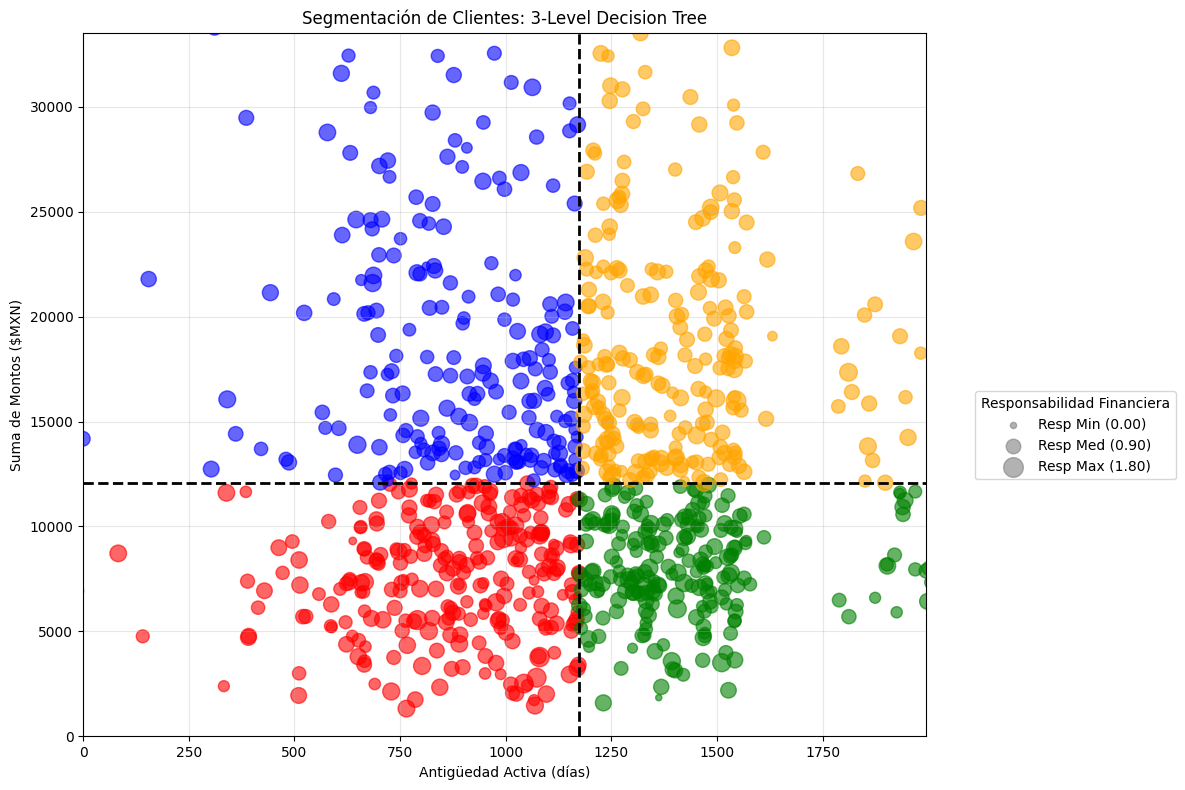


=== EJEMPLO DE PREDICCIÓN ===
Cliente predicho en Segmento: 1
Descripción: Antigüedad Baja + Monto Alto
Probabilidades:
  Antigüedad Baja + Monto Bajo: 0.000
  Antigüedad Baja + Monto Alto: 1.000
  Antigüedad Alta + Monto Bajo: 0.000
  Antigüedad Alta + Monto Alto: 0.000

=== RESUMEN FINAL ===
Árbol entrenado con 800 clientes
Precisión en test: 0.995
Umbrales utilizados:
- Antigüedad: 1174 días
- Monto: $12,061.25
El árbol tiene 2 niveles de profundidad


In [54]:
# --- STEP 1: Create 4-level target variable (2x2 = 4 categories) ---
def create_four_segment_target(df):
    """
    Creates 4-segment classification:
    0: Antiguedad Baja + Monto Bajo
    1: Antiguedad Baja + Monto Alto
    2: Antiguedad Alta + Monto Bajo
    3: Antiguedad Alta + Monto Alto
    """
    # Calculate thresholds using median (you can adjust these)
    antiguedad_umbral = df['antiguedad_activa_dias'].median()
    monto_umbral = df['monto_sum'].median()

    print(f"Umbrales calculados:")
    print(f"- Antigüedad: {antiguedad_umbral:.0f} días")
    print(f"- Monto: ${monto_umbral:,.2f}")

    # Create conditions for 4 segments
    conditions = [
        (df['antiguedad_activa_dias'] <= antiguedad_umbral) & (df['monto_sum'] <= monto_umbral),
        (df['antiguedad_activa_dias'] <= antiguedad_umbral) & (df['monto_sum'] > monto_umbral),
        (df['antiguedad_activa_dias'] > antiguedad_umbral) & (df['monto_sum'] <= monto_umbral),
        (df['antiguedad_activa_dias'] > antiguedad_umbral) & (df['monto_sum'] > monto_umbral)
    ]

    choices = [0, 1, 2, 3]

    df['segmento_4_niveles'] = np.select(conditions, choices)

    # Create descriptive labels
    segment_labels = {
        0: 'Antiguedad Baja + Monto Bajo',
        1: 'Antiguedad Baja + Monto Alto',
        2: 'Antiguedad Alta + Monto Bajo',
        3: 'Antiguedad Alta + Monto Alto'
    }

    df['segmento_descripcion'] = df['segmento_4_niveles'].map(segment_labels)

    return df, antiguedad_umbral, monto_umbral

# Apply the segmentation to your dataframe
new_df, antiguedad_threshold, monto_threshold = create_four_segment_target(new_df)

# Check distribution
print("\nDistribución de segmentos:")
segment_counts = new_df['segmento_4_niveles'].value_counts().sort_index()
for segment, count in segment_counts.items():
    percentage = (count / len(new_df)) * 100
    label = new_df[new_df['segmento_4_niveles'] == segment]['segmento_descripcion'].iloc[0]
    print(f"Segmento {segment} ({label}): {count} clientes ({percentage:.1f}%)")

# --- STEP 2: Prepare features for 3-level tree ---
# Features: id_int, giro_comercio_mean, monto_sum, antiguedad_activa_dias
X = new_df[['id_int', 'giro_comercio_mean', 'monto_sum', 'antiguedad_activa_dias']].copy()
y = new_df['segmento_4_niveles']

# Handle missing values
X = X.fillna(0)

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# --- STEP 3: Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensures balanced distribution across all segments
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# --- STEP 4: Create 3-level Decision Tree with specific structure ---
def create_structured_tree():
    """
    Creates a decision tree that first splits by antiguedad, then by monto
    """
    clf = DecisionTreeClassifier(
        max_depth=2,           # Exactly 2 levels: first antiguedad, then monto
        min_samples_split=50,  # Minimum samples to create a split
        min_samples_leaf=25,   # Minimum samples in each final leaf
        criterion='gini',      # Use gini impurity
        random_state=42,
        class_weight='balanced'  # Balance the classes automatically
    )

    return clf

# Train the model
clf = create_structured_tree()
clf.fit(X_train, y_train)

# --- STEP 5: Evaluate the model ---
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Training accuracy
train_accuracy = (y_train == y_pred_train).mean()
test_accuracy = (y_test == y_pred_test).mean()

print(f"\n=== MODEL PERFORMANCE ===")
print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

# Feature importance
print(f"\nFeature Importance:")
feature_names = ['id_int', 'giro_comercio_mean', 'monto_sum', 'antiguedad_activa_dias']
for feature, importance in zip(feature_names, clf.feature_importances_):
    print(f"- {feature}: {importance:.4f}")

# Confusion Matrix
print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

# Classification Report
segment_names = [
    'Ant.Baja+Monto.Bajo',
    'Ant.Baja+Monto.Alto',
    'Ant.Alta+Monto.Bajo',
    'Ant.Alta+Monto.Alto'
]

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=segment_names))

# --- STEP 6: Visualize the 3-level tree ---
plt.figure(figsize=(25, 15))

plot_tree(clf,
          feature_names=feature_names,
          class_names=segment_names,
          filled=True,
          rounded=True,
          fontsize=12,
          impurity=True,
          proportion=True,
          precision=2)

plt.title("3-Level Decision Tree: Antiguedad → Monto Segmentation", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# --- STEP 7: Alternative with forced structure (if needed) ---
def create_manual_segmentation(df, antiguedad_threshold, monto_threshold):
    """
    Manual segmentation to ensure the exact tree structure you want
    """
    def classify_client(row):
        if row['antiguedad_activa_dias'] <= antiguedad_threshold:
            # First branch: Low Antiguedad
            if row['monto_sum'] <= monto_threshold:
                return 0  # Low Antiguedad + Low Monto
            else:
                return 1  # Low Antiguedad + High Monto
        else:
            # Second branch: High Antiguedad
            if row['monto_sum'] <= monto_threshold:
                return 2  # High Antiguedad + Low Monto
            else:
                return 3  # High Antiguedad + High Monto

    df['manual_segment'] = df.apply(classify_client, axis=1)
    return df

# Apply manual segmentation for comparison
new_df = create_manual_segmentation(new_df, antiguedad_threshold, monto_threshold)

print(f"\n=== MANUAL SEGMENTATION VERIFICATION ===")
manual_counts = new_df['manual_segment'].value_counts().sort_index()
for segment, count in manual_counts.items():
    percentage = (count / len(new_df)) * 100
    print(f"Segmento {segment}: {count} clientes ({percentage:.1f}%)")

# Check if tree-based and manual segmentation match
tree_predictions = clf.predict(X)
match_rate = (tree_predictions == new_df['manual_segment']).mean()
print(f"\nTree vs Manual Segmentation Match Rate: {match_rate:.3f}")

# --- STEP 8: Visualization of segments ---
plt.figure(figsize=(12, 8))

# Calculate sizes based on giro_comercio_mean
# Scale the sizes to a reasonable range (20-200)
min_size, max_size = 20, 200
size_range = max_size - min_size

# Normalize giro_comercio_mean to 0-1 range for sizing
giro_min = new_df['giro_comercio_mean'].min()
giro_max = new_df['giro_comercio_mean'].max()
giro_normalized = (new_df['giro_comercio_mean'] - giro_min) / (giro_max - giro_min)
point_sizes = min_size + (giro_normalized * size_range)

# Create scatter plot with segments
colors = ['red', 'blue', 'green', 'orange']
segment_labels = [
    'Ant.Baja+Monto.Bajo',
    'Ant.Baja+Monto.Alto',
    'Ant.Alta+Monto.Bajo',
    'Ant.Alta+Monto.Alto'
]

for i, (color, label) in enumerate(zip(colors, segment_labels)):
    mask = new_df['segmento_4_niveles'] == i
    plt.scatter(
        new_df[mask]['antiguedad_activa_dias'],
        new_df[mask]['monto_sum'],
        c=color,
        label=label,
        alpha=0.6,
        s=point_sizes[mask]
    )

# Add threshold lines
plt.axvline(antiguedad_threshold, color='black', linestyle='--', linewidth=2, label='Umbral Antigüedad')
plt.axhline(monto_threshold, color='black', linestyle='--', linewidth=2, label='Umbral Monto')

plt.xlabel('Antigüedad Activa (días)')
plt.ylabel('Suma de Montos ($MXN)')
plt.title('Segmentación de Clientes: 3-Level Decision Tree')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add size legend for giro_comercio_mean
# giro_comercio_mean describes the level of responsibility of the user.
size_legend_elements = [
    plt.scatter([], [], s=min_size, c='gray', alpha=0.6, label=f'Resp Min ({giro_min:.2f})'),
    plt.scatter([], [], s=(min_size + max_size)/2, c='gray', alpha=0.6, label=f'Resp Med ({(giro_min + giro_max)/2:.2f})'),
    plt.scatter([], [], s=max_size, c='gray', alpha=0.6, label=f'Resp Max ({giro_max:.2f})')
]
size_legend = plt.legend(handles=size_legend_elements, title='Responsabilidad Financiera',
                        loc='upper left', bbox_to_anchor=(1.05, 0.5))

# Focus on main data area (remove extreme outliers for better visualization)
plt.xlim(0, new_df['antiguedad_activa_dias'].quantile(0.95))
plt.ylim(0, new_df['monto_sum'].quantile(0.95))

plt.tight_layout()
plt.show()

# --- STEP 9: Function to predict new clients ---
def predict_client_segment(model, client_data, feature_names):
    """
    Predicts the segment of a new client
    """
    client_df = pd.DataFrame([client_data], columns=feature_names)
    client_df = client_df.fillna(0)

    prediction = model.predict(client_df)[0]
    probabilities = model.predict_proba(client_df)[0]

    segment_descriptions = {
        0: 'Antigüedad Baja + Monto Bajo',
        1: 'Antigüedad Baja + Monto Alto',
        2: 'Antigüedad Alta + Monto Bajo',
        3: 'Antigüedad Alta + Monto Alto'
    }

    print(f"Cliente predicho en Segmento: {prediction}")
    print(f"Descripción: {segment_descriptions[prediction]}")
    print(f"Probabilidades:")
    for i, prob in enumerate(probabilities):
        print(f"  {segment_descriptions[i]}: {prob:.3f}")

    return prediction

# Example usage:
print(f"\n=== EJEMPLO DE PREDICCIÓN ===")
# Example new client data
example_client = {
    'id_int': 999999,
    'giro_comercio_mean': 1.5,
    'monto_sum': 15000,
    'antiguedad_activa_dias': 800
}

prediction = predict_client_segment(clf, example_client, feature_names)

print(f"\n=== RESUMEN FINAL ===")
print(f"Árbol entrenado con {len(X_train)} clientes")
print(f"Precisión en test: {test_accuracy:.3f}")
print(f"Umbrales utilizados:")
print(f"- Antigüedad: {antiguedad_threshold:.0f} días")
print(f"- Monto: ${monto_threshold:,.2f}")
print(f"El árbol tiene {clf.tree_.max_depth} niveles de profundidad")

# Resumen del Life Time Value



In [64]:

# Cargar datos

clientes = pd.read_csv("base_clientes_final.csv")

transacciones = pd.read_csv("base_transacciones_final.csv")



# Asegurar formato de fecha

clientes["fecha_alta"] = pd.to_datetime(clientes["fecha_alta"], errors="coerce", dayfirst=True)

transacciones["fecha"] = pd.to_datetime(transacciones["fecha"], errors="coerce")



# Calcular fecha de última transacción por cliente

ultima_fecha = transacciones.groupby("id")["fecha"].max().reset_index()

ultima_fecha.columns = ["id", "fecha_ultima_transaccion"]



# Unir con clientes

clientes = pd.merge(clientes, ultima_fecha, on="id", how="left")



# Calcular duración de permanencia en días

clientes["tiempo_en_banco_dias"] = (clientes["fecha_ultima_transaccion"] - clientes["fecha_alta"]).dt.days



# Calcular en meses o años si prefieres

clientes["tiempo_en_banco_meses"] = (clientes["tiempo_en_banco_dias"] / 30).round(1)



# Cargar segmentos (ya generados con matriz BCG)
segmentos = pd.read_csv("bcg_clientes_segmentados.csv")  # contiene columnas: id, Segmento

clientes = pd.merge(clientes, segmentos[["id", "Segmento"]], on="id", how="left")



# Agrupar por segmento y obtener promedio de tiempo

resumen = clientes.groupby("Segmento")["tiempo_en_banco_meses"].agg(["count", "mean", "min", "max"]).round(1).reset_index()

resumen.columns = ["Segmento", "Número de Clientes", "Permanencia Promedio (meses)", "Mínimo", "Máximo"]



# Ver resultado

print(resumen)

   Segmento  Número de Clientes  Permanencia Promedio (meses)  Mínimo  Máximo
0  Cash Cow                 182                          42.3    13.3    57.0
1   Dormido                 566                          42.7     6.9    57.4
2  Estrella                  68                          65.5    54.6   101.1
3   Promesa                 184                          65.9    48.5   109.9


In [86]:
print(both_id.shape)
print(both_id.head(5))

#
star = 0
cow = 0
sleep = 0
future = 0

antiguedad_threshold_bcg = 1174 # Using the hardcoded value from your code for the BCG part
monto_threshold_bcg = 12061.25 # Using the hardcoded value from your code for the BCG part

# Check if required columns exist in both_id
if 'monto_sum' not in both_id.columns or 'antiguedad_activa_dias' not in both_id.columns:
    print("Error: 'monto_sum' or 'antiguedad_activa_dias' not found in both_id.")
    # You might need to re-evaluate how both_id was created or merge correctly if needed.
else:
    star = both_id[(both_id['monto_sum'] > monto_threshold_bcg) & (both_id['antiguedad_activa_dias'] > antiguedad_threshold_bcg)]['monto_sum'].sum() * 65.5
    cow = both_id[(both_id['monto_sum'] > monto_threshold_bcg) & (both_id['antiguedad_activa_dias'] <= antiguedad_threshold_bcg)]['monto_sum'].sum() * 42.7
    sleep = both_id[(both_id['monto_sum'] <= monto_threshold_bcg) & (both_id['antiguedad_activa_dias'] <= antiguedad_threshold_bcg)]['monto_sum'].sum() * 42.3
    future = both_id[(both_id['monto_sum'] <= monto_threshold_bcg) & (both_id['antiguedad_activa_dias'] > antiguedad_threshold_bcg)]['monto_sum'].sum() * 65.9

    print(star)
    print(cow)
    print(sleep)
    print(future)

# Merge monto_sum with segments to get the segment for each customer
monto_sum_with_segment = pd.merge(monto_sum, segmentos[['id', 'Segmento']], on='id', how='left')

# Merge monto_sum_with_segment with resumen to get the average permanence for each segment
# Rename 'Segmento' in resumen to avoid conflict during merge if needed
resumen_permanencia = resumen[['Segmento', 'Permanencia Promedio (meses)']].rename(columns={'Segmento': 'Segmento'})

monto_sum_with_permanencia = pd.merge(monto_sum_with_segment, resumen_permanencia, on='Segmento', how='left')

# Calculate LTV for each customer: monto_sum * Permanencia Promedio (meses)
# Handle potential missing permanence data (e.g., for segments not in resumen)
monto_sum_with_permanencia['LTV'] = monto_sum_with_permanencia['monto_sum'] * monto_sum_with_permanencia['Permanencia Promedio (meses)'].fillna(0) # Fill NaN permanence with 0

print("\nLTV per customer:")
print(monto_sum_with_permanencia[['id', 'monto_sum', 'Segmento', 'Permanencia Promedio (meses)', 'LTV']].head())

(1000, 17)
                                         id fecha_nacimiento fecha_alta  \
0  9980f12e32711330d5f58460e169e6207afda041       19/06/1984 2015-10-25   
1  93512ea145c3d81ba7a7ff641faf992fd307072e       21/12/1986 2018-02-11   
2  acb2fee5aea2d73a88359d438aaedeea731554f8       01/02/1991 2019-05-12   
3  b627227d2f20116510bcb12de34e6a188cf8d054       23/05/1994 2017-07-19   
4  054be5f40d50b28d2b82af57159343989dd28012       03/10/1990 2017-05-21   

   id_municipio  id_estado                              tipo_persona genero  \
0       6822006         68  Persona Fisica Sin Actividad Empresarial          
1       6822014         68  Persona Fisica Con Actividad Empresarial      F   
2       6115121         61  Persona Fisica Con Actividad Empresarial      M   
3       6923005         69  Persona Fisica Sin Actividad Empresarial      F   
4       6014120         60  Persona Fisica Sin Actividad Empresarial      M   

                               actividad_empresarial fecha_ulti

In [87]:
ltv_sum_by_permanencia = monto_sum_with_permanencia.groupby('Permanencia Promedio (meses)')['LTV'].sum().reset_index()

print("\nSum of LTV per unique 'Permanencia Promedio (meses)' value:")
print(ltv_sum_by_permanencia)


Sum of LTV per unique 'Permanencia Promedio (meses)' value:
   Permanencia Promedio (meses)           LTV
0                          42.3  2.261469e+08
1                          42.7  2.391700e+08
2                          65.5  1.161589e+08
3                          65.9  1.260138e+08
